# Analysis Primer

## Opening CSD Files

Use the `pathlib` library to define a path to the CSD file of interest, make sure this is the `csd` file and that the datasheet file `dsht` is in the same directory

In [1]:
from pathlib import Path
%cd ..
csd_path = Path('./data/csds/csd_1743103884')
csd_path.exists()

/home/work/repos/ops/ecris.analysis


True

Load the file into a `CSD` object using the function `read_csd_from_file_pair`

In [2]:
from ops.ecris.analysis.io.read_csd_file import read_csd_from_file_pair
csd = read_csd_from_file_pair(csd_path)

The `CSD` object contains all the parsed data on the CSD:

In [3]:
import numpy as np

print(csd.timestamp)
print(csd.dipole_current)
print(csd.beam_current)
print(csd.time)

# Raw Data
print(np.shape(csd.data))

2025-03-27 12:31:24
[3.34580e+07 3.35910e+07 3.37240e+07 ... 1.08823e+08 1.08864e+08
 1.08905e+08]
[0.0714788 0.0458844 0.0589791 ... 0.142492  0.107639  0.168885 ]
[1.74310389e+09 1.74310389e+09 1.74310389e+09 ... 1.74310390e+09
 1.74310390e+09 1.74310390e+09]
(1200, 4)


The CSD does not have an `m_over_q` set yet, this must be found by fitting.

In [4]:
print(csd.m_over_q is None)

True


The `m_over_q` value can be estimated using the constant $\alpha$, this does not modify the CSD in place but returns the M/Q array

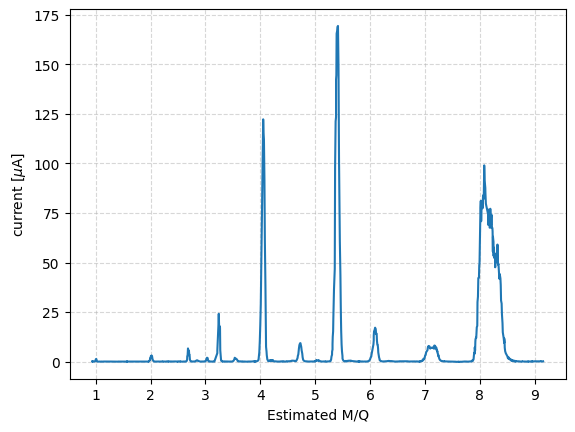

In [5]:
import matplotlib.pyplot as plt
from ops.ecris.analysis.csd.m_over_q import estimate_m_over_q

csd.m_over_q = estimate_m_over_q(csd)
plt.plot(csd.m_over_q, csd.beam_current)
plt.grid(alpha=0.5, ls='--')
plt.xticks(range(1, 10))
plt.ylabel(r'current [$\mu$A]')
plt.xlabel('Estimated M/Q')
plt.show()

## Linear Rescaling using Oxygen

To scale the M/Q array using an element with expected peaks, use the function `rescale_with_element` and an `Element` object. Note that this _does_ change the CSD in place

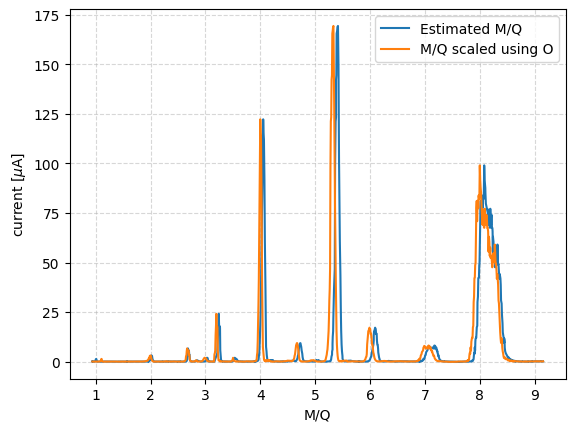

In [6]:
from ops.ecris.analysis.csd.m_over_q import rescale_with_element
from ops.ecris.analysis.model.element import Element

csd = read_csd_from_file_pair(csd_path)
csd.m_over_q = estimate_m_over_q(csd)
oxygen = Element('Oxygen', 'O', atomic_mass=16, atomic_number=8)
plt.plot(csd.m_over_q, csd.beam_current, label='Estimated M/Q')
rescale_with_element(csd, oxygen)
plt.plot(csd.m_over_q, csd.beam_current, label=r'M/Q scaled using O')
plt.grid(alpha=0.5, ls='--')
plt.xticks(range(1, 10))
plt.ylabel(r'current [$\mu$A]')
plt.xlabel('M/Q')
plt.legend()
plt.show()

For ease of use, there is a function that automatically estimates and then rescales the M/Q value using Oxygen, as well as a plotting tool

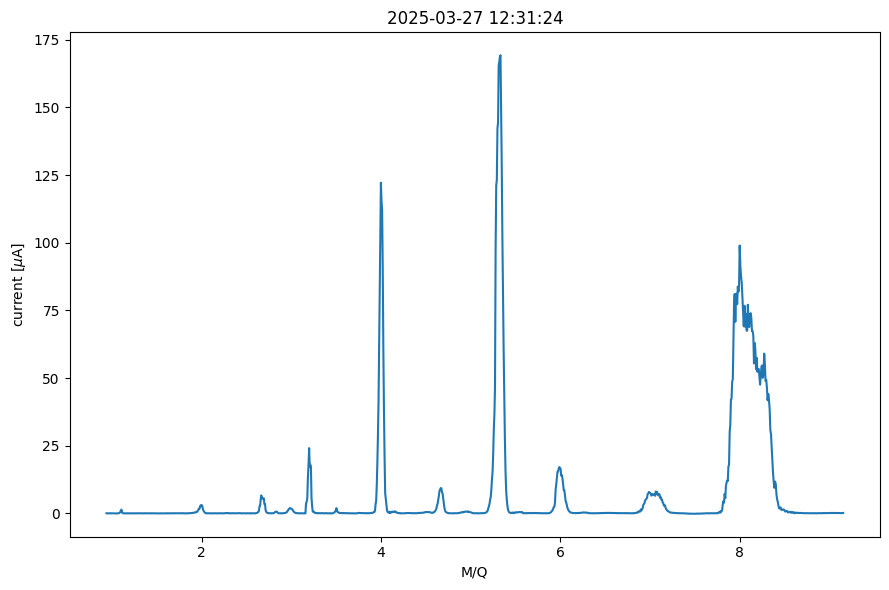

In [7]:
from ops.ecris.analysis.csd.m_over_q import rescale_with_oxygen
from ops.ecris.analysis.plot import plot_csd

csd = None
csd = read_csd_from_file_pair(csd_path)
rescale_with_oxygen(csd)
fig = plot_csd(csd)

## Polynomial Rescaling using Oxygen

The polynomial scaling routine also uses oxygen peaks but fits the M/Q axis using a polynomial fit (Legendre polynomials up to 3rd degree)

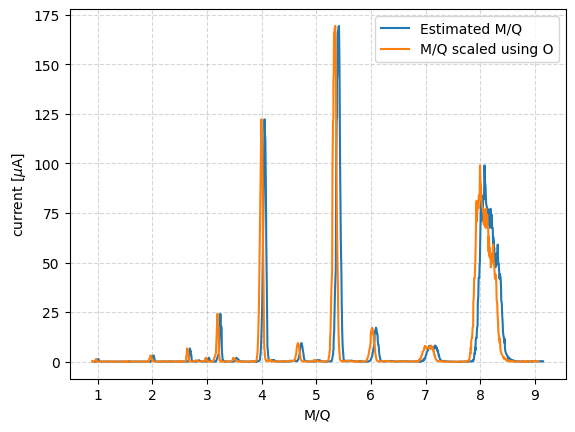

In [10]:
from ops.ecris.analysis.csd.polynomial_fit import default_polynomial_fit
from ops.ecris.analysis.csd.m_over_q import estimate_m_over_q
from ops.ecris.analysis.model.element import Element

csd = read_csd_from_file_pair(csd_path)
plt.plot(estimate_m_over_q(csd), csd.beam_current, label='Estimated M/Q')
csd.m_over_q, solution = default_polynomial_fit(csd)
plt.plot(csd.m_over_q, csd.beam_current, label=r'M/Q scaled using O')
plt.grid(alpha=0.5, ls='--')
plt.xticks(range(1, 10))
plt.ylabel(r'current [$\mu$A]')
plt.xlabel('M/Q')
plt.legend()
plt.show()

Even if the solution doesn't converge, the fit is usually good.

In [12]:
print(solution)

 message: Number of function evaluations done is larger than maxfun=3000
 success: False
  status: 1
     fun: -40939.73613384181
       x: [-3.570e-02  9.942e-01  0.000e+00]
     nit: 310
    nfev: 3013


The fitting routine can be customized using a specified element or solver parameters.

 message: The volume of the hyperrectangle containing the lowest function value found is below vol_tol=1e-16
 success: True
  status: 4
     fun: -53422.33887638258
       x: [ 0.000e+00  9.873e-01  0.000e+00  0.000e+00]
     nit: 17
    nfev: 461


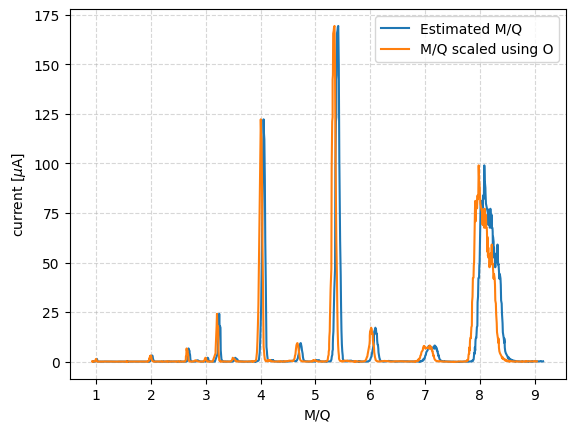

In [14]:
from ops.ecris.analysis.csd.polynomial_fit import polynomial_fit_mq
from ops.ecris.analysis.model import Element

csd = read_csd_from_file_pair(csd_path)
plt.plot(estimate_m_over_q(csd), csd.beam_current, label='Estimated M/Q')

elements = [Element('Oxygen', 'O', 15.9949, 8), 
            Element('Carbon', 'C', 12, 6)]
csd.m_over_q, solution = polynomial_fit_mq(
    csd, 
    elements=elements, # Elements to use for fit (Can just be a list of one)
    polynomial_order=4, # Legendre polynomial order
    max_iterations = 2000, # Max optimization iterations
    max_function_evaluations=10000) # Max function evaluations
print(solution)
plt.plot(csd.m_over_q, csd.beam_current, label=r'M/Q scaled using O')
plt.grid(alpha=0.5, ls='--')
plt.xticks(range(1, 10))
plt.ylabel(r'current [$\mu$A]')
plt.xlabel('M/Q')
plt.legend()
plt.show()